In [1]:
from utils_3_v1 import *
import pandas as pd
import numpy as np
import glob
from keras.utils import np_utils
import multiprocessing
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
path_to_midway = '/scratch/midway2/reshmask/' #change your scratch/home directory to save and load npy files
date           = '1003'
pool           = multiprocessing.Pool(processes=multiprocessing.cpu_count()) # multiprocessing initialization

### Loading metadata:
* Loading filtered mp3 audio speech files (52433, 8) - Refer to notebook 1

In [14]:
print('Loading metadata')
filtered_audios = pd.read_csv('FilteredMP3.csv')
filtered_audios['filename'] = filtered_audios['filename'].apply(lambda x: x.replace('.mp3','.wav'))
filtered_audios.shape

Loading metadata


(52433, 8)

### Create dummies for Gender and Age:
* Age dummies : 'seventies', 'thirties', 'twenties', 'sixties', 'fourties', 'fifties', 'teens', 'eighties'
* Gender dummies : 'male', 'female'

In [15]:
filtered_audios_dummies= pd.concat([filtered_audios['filename'],filtered_audios['accent'], pd.get_dummies(filtered_audios['gender']), pd.get_dummies(filtered_audios['age'])], axis=1)

In [5]:
# print('Checking stats of accent')
# filtered_audios_dummies['accent'].value_counts(normalize=True)

### Filtered accent:
* Selected top 5 accents by looking at the distribution; 'US', 'England', 'Canada', 'Indian', 'Australia'
* Shape of the filtered file is 41366, 8
* Mapped accent category to number 

In [16]:
accent_dict = {'us':0, 'australia':1, 'england':2, 'indian':3, 'canada':4, 'scotland':5,
       'african':6, 'newzealand':7, 'ireland':8, 'bermuda':9, 'wales':10, 'malaysia':11,
       'philippines':12, 'hongkong':13, 'singapore':14, 'southatlandtic':15}
filtered_audios_dummies['accent'] = filtered_audios_dummies['accent'].map(accent_dict)
filtered_audios_dummies_accent    = filtered_audios_dummies[filtered_audios_dummies['accent'].isin([0, 1, 2, 3, 4])]
filtered_audios_dummies_accent.shape

(41366, 12)

In [17]:
filtered_audios_dummies_accent = filtered_audios_dummies_accent[:100] #-- for testing purpose

### Seperate and split train, validation and test set:
* X = array of filenames, Y = array of top 5 accents
* Split train, val, test into 50%, 20% and 30%
* Stratified accent for all 3 sets to have equal distribution of y

In [18]:
X = filtered_audios_dummies_accent.drop('accent', axis=1)#['filename'].values
Y = filtered_audios_dummies_accent['accent'].values

In [19]:
X_, X_test, Y_, y_test = train_test_split(X, Y, test_size=0.30, random_state=99, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2855, random_state=99, stratify=Y_)

In [20]:
print ('shape of train file:', X_train.shape)
print ('shape of validation file:', X_val.shape)
print ('shape of test file:', X_test.shape)

shape of train file: (50, 11)
shape of validation file: (20, 11)
shape of test file: (30, 11)


### Read wav file for train and test:
* Multiprocessed both train and test data files
* Used librosa library to load wav files

In [21]:
print('Loading wav files....')
start_time  = time.time()
train_wav   = pool.map(get_wav, X_train['filename'].values)
val_wav     = pool.map(get_wav, X_val['filename'].values)
test_wav    = pool.map(get_wav, X_test['filename'].values)
print('total time for processing is:', (time.time()- start_time)/60.0)

Loading wav files....
total time for processing is: 0.44027260144551594


### Save train, test and validation wav file:
 * Saving y and X for train, test and validation

In [12]:
# np.save(path_to_midway + 'train_wav.npy', train_wav)
# np.save(path_to_midway + 'val_wav.npy', val_wav)
# np.save(path_to_midway + 'test_wav.npy', test_wav)

# np.save(path_to_midway + 'y_train.npy', y_train)
# np.save(path_to_midway + 'y_test.npy', y_test)
# np.save(path_to_midway + 'y_val.npy', y_val)

# X_train.to_csv(path_to_midway+'X_train.csv', index=False)
# X_test.to_csv(path_to_midway+'X_test.csv', index=False)
# X_val.to_csv(path_to_midway+'X_val.csv', index=False)

### Load npy train, test and validation wav file:

In [14]:
train_wav = np.load('/scratch/midway2/reshmask/train_wav.npy', allow_pickle=True)
test_wav  = np.load('/scratch/midway2/reshmask/test_wav.npy', allow_pickle=True)
val_wav   = np.load('/scratch/midway2/reshmask/val_wav.npy', allow_pickle=True)

y_train   = np.load('/scratch/midway2/reshmask/y_train.npy', allow_pickle=True)
y_test    = np.load('/scratch/midway2/reshmask/y_test.npy', allow_pickle=True)
y_val     = np.load('/scratch/midway2/reshmask/y_val.npy', allow_pickle=True)

X_train   = pd.read_csv(path_to_midway+'X_train.csv')
X_test    = pd.read_csv(path_to_midway+'X_test.csv')
X_val     = pd.read_csv(path_to_midway+'X_val.csv')

### Trim log silences/pauses in train and test:

In [22]:
print('Trimming wav files....')
start_time  = time.time()
train_trim  = pool.map(trim_long_silences, train_wav)
val_trim    = pool.map(trim_long_silences, val_wav)
test_trim   = pool.map(trim_long_silences, test_wav)
print('total time for processing is:', (time.time()- start_time)/60.0)

Trimming wav files....
total time for processing is: 0.015724591414133706


### Feature extraction using Kaldi-toolkit:
* mfcc - 13 (12 cfpc coef, 1 energy)
* filterbank - 32
* delta_1, delta_2 - 64 each
* Frame level accent vector

In [24]:
print('Get Kaldi features....')
start_time      = time.time()
train_features, y_train_, train_len_  = get_kaldi_features(train_trim, y_train, X_train)
val_features, y_val_, val_len_        = get_kaldi_features(val_trim, y_val, X_val)
test_features, y_test_, test_len_     = get_kaldi_features(test_trim, y_test, X_test)
print('total time for processing is:', (time.time()- start_time)/60.0)

Get Kaldi features....
total time for processing is: 0.0762460986773173


In [25]:
# print('Get Kaldi features....')
# start_time = time.time()
# train_arr  = pool.starmap(get_kaldi_features, zip(train_trim, y_train, X_train.values))
# val_arr    = pool.starmap(get_kaldi_features, zip(val_trim, y_val, X_val.values))
# test_arr   = pool.starmap(get_kaldi_features, zip(test_trim, y_test, X_test.values))
# print('total time for processing is:', (time.time()- start_time)/60.0)

In [26]:
# print('Convert feature form....')
# start_time                            = time.time()
# train_features, y_train_, train_len_  = convert_feat_form(train_arr)
# val_features, y_val_, val_len_        = convert_feat_form(val_arr)
# test_features, y_test_, test_len_     = convert_feat_form(test_arr)
# print('total time for processing is:', (time.time()- start_time)/60.0)

### Training a Model:
* conv1D

In [28]:
# batch_size  = 100 
# epochs      = 20 
nb_classes  = 5 
input_shape = (train_features.shape[1],1) 
input_shape

(119, 1)

In [22]:
Y_train    = np_utils.to_categorical(y_train_, nb_classes)
Y_val      = np_utils.to_categorical(y_val_, nb_classes)

xts        = train_features.shape
train_X    = np.reshape(train_features, (xts[0], xts[1], 1))
xtv        = val_features.shape
val_X      = np.reshape(val_features, (xtv[0], xtv[1], 1))
xtt        = test_features.shape
test_X     = np.reshape(test_features, (xtt[0], xtt[1], 1))

In [23]:
model_history, nn_blstm = train_blstm_model(train_X, Y_train, val_X, Y_val, input_shape)

Train on 21109 samples, validate on 7903 samples
Epoch 1/20
21109/21109 [==============================] - 25s 1ms/step - loss: 1.2649 - convo_f1_score: 0.3959 - val_loss: 1.1848 - val_convo_f1_score: 0.3837
Epoch 2/20
21109/21109 [==============================] - 24s 1ms/step - loss: 1.0046 - convo_f1_score: 0.5387 - val_loss: 1.5142 - val_convo_f1_score: 0.4967
Epoch 3/20
21109/21109 [==============================] - 22s 1ms/step - loss: 0.8426 - convo_f1_score: 0.6352 - val_loss: 1.4646 - val_convo_f1_score: 0.4487
Epoch 4/20
21109/21109 [==============================] - 22s 1ms/step - loss: 0.6695 - convo_f1_score: 0.7386 - val_loss: 1.6741 - val_convo_f1_score: 0.4719
Epoch 00004: early stopping


In [27]:
model_history.history.keys()

dict_keys(['val_loss', 'val_convo_f1_score', 'loss', 'convo_f1_score'])

dict_keys(['val_loss', 'val_convo_f1_score', 'loss', 'convo_f1_score'])


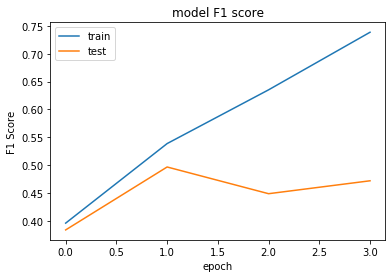

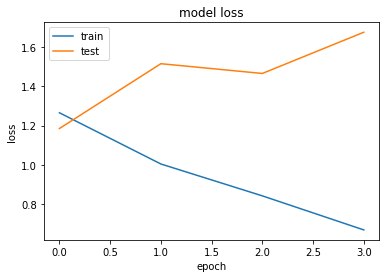

In [29]:
print('plotting train and test accuracy/f1-score/loss')
# summarize history for accuracy
plt.plot(model_history.history['convo_f1_score'])
plt.plot(model_history.history['val_convo_f1_score'])
plt.title('model F1 score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path_to_midway+'blstm_f1_score.png'.format(date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path_to_midway+'blstm_loss.png'.format(date), bbox_inches='tight')
plt.show()

### Save conv1D model

In [ ]:
print ('saving a model file')
nn_1d.save(path_to_midway+"nn_blstm.h5")

### Prediction for test set:
* Calculate frame level accuracy

In [33]:
y_pred_test     = nn_blstm.predict(test_X)
y_pred_test_cls = np.argmax(y_pred_test, axis=1)

In [34]:
y_pred_val     = nn_blstm.predict(val_X)
y_pred_val_cls = np.argmax(y_pred_val, axis=1)

In [35]:
y_pred_train     = nn_blstm.predict(train_X) 
y_pred_train_cls = np.argmax(y_pred_train, axis=1)

In [36]:
print ('Frame level accuracy for train set:', accuracy_score(y_train_, y_pred_train_cls))

Frame level accuracy for train set: 0.7700506892794543


In [37]:
print ('Frame level accuracy for val set:', accuracy_score(y_val_, y_pred_val_cls))

Frame level accuracy for val set: 0.48551183095027206


In [38]:
print ('Frame level accuracy for test set:', accuracy_score(y_test_, y_pred_test_cls))

Frame level accuracy for test set: 0.48374419435512683


### Get speaker level accuracy:
* Combine frame level accent ouput to find a major accent label for a speaker

In [39]:
y_pred_train_cls_sp = get_speaker_pred(train_len_['frame_len'].values, y_pred_train_cls)
y_pred_test_cls_sp  = get_speaker_pred(test_len_['frame_len'].values, y_pred_test_cls)
y_pred_val_cls_sp   = get_speaker_pred(val_len_['frame_len'].values, y_pred_val_cls)

In [40]:
print ('Speaker level accuracy for train:', accuracy_score(train_len_['accent'], y_pred_train_cls_sp))

Speaker level accuracy for train: 0.8


In [41]:
print ('Speaker level accuracy for val:',   accuracy_score(val_len_['accent'], y_pred_val_cls_sp))

Speaker level accuracy for val: 0.5


In [42]:
print ('Speaker level accuracy for test:',  accuracy_score(test_len_['accent'], y_pred_test_cls_sp))

Speaker level accuracy for test: 0.5666666666666667


In [54]:
print ('saving classification reports at speaker level..')
save_report('nn_bsltm_train',train_len_['accent'], y_pred_train_cls_sp)
save_report('nn_blstm_val',val_len_['accent'], y_pred_val_cls_sp)
save_report('nn_blstm_test',test_len_['accent'], y_pred_test_cls_sp)

saving classification reports at speaker level..


In [ ]:
all_classes = ['US', 'Australia', 'England', 'Indian', 'Canada']

In [ ]:
print ('saving confusion matrix at speaker level..')
save_cm('nn_blstm_train_cm',train_len_['accent'], y_pred_train_cls_sp, all_classes)
save_cm('nn_blstm_val_cm',val_len_['accent'], y_pred_val_cls_sp, all_classes)
save_cm('nn_blstm_test_cm',test_len_['accent'], y_pred_test_cls_sp, all_classes)

In [ ]:
# Frame level accuracy for train set: 0.8274350195402107
# Frame level accuracy for val set: 0.7432034065709191
# Frame level accuracy for test set: 0.7424890623253455
# Speaker level accuracy for train: 0.9350360373433948
# Speaker level accuracy for val: 0.8380963913780577
# Speaker level accuracy for test: 0.8385223423132764

In [17]:
# nn_blstm = train_blstm_model(train_X, Y_train, val_X, Y_val, input_shape)

C:\Users\SSK\Documents\UC - MScA\Courses\04-Spring_2020\04-DeepLearning\Project\data_to_explore\utils_3_v1.py:270: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(train_X, Y_train, batch_size=batch_size, nb_epoch=5, validation_data=(val_X, Y_val))


Train on 21109 samples, validate on 7903 samples
Epoch 1/5
21109/21109 [==============================] - 374s 18ms/step - loss: 1.2914 - accuracy: 0.4977 - val_loss: 1.1550 - val_accuracy: 0.4968
Epoch 2/5
21109/21109 [==============================] - 470s 22ms/step - loss: 1.2136 - accuracy: 0.5269 - val_loss: 1.1403 - val_accuracy: 0.4913
Epoch 3/5
21109/21109 [==============================] - 770s 36ms/step - loss: 1.1931 - accuracy: 0.5264 - val_loss: 1.1434 - val_accuracy: 0.4896
Epoch 4/5
21109/21109 [==============================] - 962s 46ms/step - loss: 1.1597 - accuracy: 0.5284 - val_loss: 1.1735 - val_accuracy: 0.4797
Epoch 5/5
21109/21109 [==============================] - 1057s 50ms/step - loss: 1.1072 - accuracy: 0.5441 - val_loss: 1.2164 - val_accuracy: 0.4954
